# Configuration
A sample of the best configuration for the job

In [12]:
import matplotlib.pyplot as plt

import gym_duckietown
import gym

In [25]:
env = gym.make("Duckietown-small_loop-v0",
    full_transparency=True,
    accept_start_angle_deg=1, #Should be 0 but takes a long time for reasons unknown
    domain_rand=False,
    user_tile_start=[1,2],
)

INFO:gym-duckietown:Information about the graphics card:
 pyglet_version: 1.5.21
    information: dict[4]
                 │ vendor: Intel
                 │ renderer: Mesa Intel(R) HD Graphics 5500 (BDW GT2)
                 │ version: 4.6 (Compatibility Profile) Mesa 21.0.3
                 │ shading-language-version: 4.60
  nvidia_around: False
DEBUG:gym-duckietown:loading map file "/home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages/duckietown_world/data/gd1/maps/small_loop.yaml"
INFO:gym-duckietown:done
INFO:gym-duckietown:using user tile start: [1, 2]
DEBUG:gym-duckietown:tile: {'coords': (1, 2), 'kind': 'straight', 'angle': 1, 'drivable': True, 'curves': array([[[0.585  , 0.     , 1.5795 ],
        [0.73125, 0.     , 1.5795 ],
        [1.02375, 0.     , 1.5795 ],
        [1.17   , 0.     , 1.5795 ]],

       [[1.17   , 0.     , 1.3455 ],
        [1.02375, 0.     , 1.3455 ],
        [0.73125, 0.     , 1.3455 ],
        [0.585  , 0.     , 1.3455 ]]]), 'texture': <gym_d

INFO:gym-duckietown:using user tile start: [1, 2]
DEBUG:gym-duckietown:tile: {'coords': (1, 2), 'kind': 'straight', 'angle': 1, 'drivable': True, 'curves': array([[[0.585  , 0.     , 1.5795 ],
        [0.73125, 0.     , 1.5795 ],
        [1.02375, 0.     , 1.5795 ],
        [1.17   , 0.     , 1.5795 ]],

       [[1.17   , 0.     , 1.3455 ],
        [1.02375, 0.     , 1.3455 ],
        [0.73125, 0.     , 1.3455 ],
        [0.585  , 0.     , 1.3455 ]]]), 'texture': <gym_duckietown.graphics.Texture object at 0x7f597cb44100>, 'color': array([1, 1, 1, 1])}
DEBUG:gym-duckietown:No tile found at [0.81271254 0.         1.80484505] (1, 3)
DEBUG:gym-duckietown:Invalid pose. Collision free: True On drivable area: False
DEBUG:gym-duckietown:safety_factor: 1.3
DEBUG:gym-duckietown:pos: [0.8393281  0.         1.71104813]
DEBUG:gym-duckietown:l_pos: [0.81271254 0.         1.80484505]
DEBUG:gym-duckietown:r_pos: [0.86594366 0.         1.61725121]
DEBUG:gym-duckietown:f_pos: [0.7267718  0.         1.67

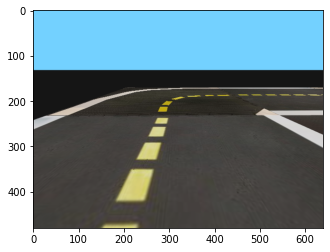

In [27]:
plt.imshow(env.reset())

In [22]:
env.get_agent_info()

{'Simulator': {'action': [0, 0],
  'lane_position': {'dist': -0.02677871695769407,
   'dot_dir': 0.9910696630610891,
   'angle_deg': -7.662937490556034,
   'angle_rad': -0.1337434895847147},
  'robot_speed': 0.0,
  'proximity_penalty': 0,
  'cur_pos': [0.9356193160953599, 0.0, 1.552721283042306],
  'cur_angle': 0.13374348958471444,
  'wheel_velocities': [0, 0],
  'timestamp': 0.0,
  'tile_coords': [1, 2]}}